In [1]:
# Run this cell first, then restart the runtime/kernel before running any other cell
!pip uninstall -y bitsandbytes && \
pip install --upgrade --force-reinstall \
    numpy==1.26.4 pandas==2.2.2 \
    transformers sentence-transformers \
    textattack datasets nltk matplotlib tqdm \
    bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 97.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 101.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 65.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ..

In [9]:
# === Imports and Setup ===
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
import os
import torch
import nltk
import re
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from textattack.augmentation.recipes import WordNetAugmenter, CharSwapAugmenter, CLAREAugmenter
from nltk.corpus import wordnet
import torch.nn.functional as F

In [ ]:
# configure environment
HF_TOKEN = ""
os.environ["HF_TOKEN"] = HF_TOKEN

# # download wordnet resources
# nltk.download('omw-1.4')
# nltk.download('wordnet')

# ! unzip /usr/share/nltk_data/corpora/omw-1.4.zip -d /usr/share/nltk_data/corpora > /dev/null
# ! mv /usr/share/nltk_data/corpora/omw-1.4 /usr/share/nltk_data/corpora/omw
# ! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

model_id = "ContactDoctor/Bio-Medical-Llama-3-8B" # set the model id
device = 0  # CUDA 0 (to force GPU usage)

qa_pipeline = pipeline(
    "text-generation", # make sure its text generation
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map=device
)

# initialise semantic model
semantic_model = SentenceTransformer("all-MiniLM-L6-v2", device=device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [11]:
# function to extract answer letter in case the model is giving other words apart from the option letter (used for accuracy calculations)
def extract_answer_letter(text):
    match = re.search(r"\b([A-D])\b", text.upper())
    return match.group(1) if match else ""

# used for robustness evaluation with accuracy
def build_prompt(question_text, opts):
    return (
        "You are a knowledgeable medical expert. Read the following question carefully and choose the most appropriate answer from the options provided. "
        "Respond with only the letter corresponding to your answer choice (A, B, C or D).\n\n"
        f"Question:\n{question_text}\n\n"
        f"Options:\n"
        f"A. {opts[0]}\n"
        f"B. {opts[1]}\n"
        f"C. {opts[2]}\n"
        f"D. {opts[3]}\n\n"
        "Answer:"
    )

# used for adversarial training
def build_explained_prompt(question_text, opts):
    return (
        "You are a knowledgeable medical expert. Carefully analyse the following question and provide a short explanation for which option you think is most appropriate, based on reasoning. You do not need to give just the letter.\n\n"
        f"Question:\n{question_text}\n\n"
        f"Options:\n"
        f"A. {opts[0]}\n"
        f"B. {opts[1]}\n"
        f"C. {opts[2]}\n"
        f"D. {opts[3]}\n\n"
        "Answer and explanation:"
    )
# load the dataset (50 random question and answer sets from medMCQA)
dataset = load_dataset("medmcqa", split="validation")
dataset = dataset.filter(lambda example: example["choice_type"] == "single")
dataset = dataset.shuffle(seed=42).select(range(50))

questions = [ex["question"] for ex in dataset] # extract question text from dataset
options_list = [[ex["opa"], ex["opb"], ex["opc"], ex["opd"]] for ex in dataset] # extract the 4 options
correct_indices = [int(ex["cop"]) for ex in dataset] # extract the index of the correct option
correct_letters = [chr(ord('A') + idx) for idx in correct_indices] # extract the correct letter

# generate the original prompts for robustness accuracy calculation, and get the original outputs
original_prompts = [build_prompt(q, opts) for q, opts in zip(questions, options_list)]
orig_outputs = qa_pipeline(original_prompts, max_new_tokens=30, batch_size = 8)

original_letters = []
original_correct_flags = []

# iterate over the questions and store the answers to the original prompt and whether the model got it right
for i in range(len(questions)):
    response = orig_outputs[i][0]['generated_text'].replace(original_prompts[i], "").strip()
    letter = extract_answer_letter(response)
    original_letters.append(letter)
    original_correct_flags.append(int(letter == correct_letters[i]))

print("Original model predictions saved successfully.")

# pertubation loop
perturbation_levels = [0.3, 0.5, 0.7]
batch_size = 8
all_results = []

for perturbation_level in perturbation_levels:
    print(f"\n=== Evaluating Perturbation Level: {int(perturbation_level * 100)}% ===")

    # initialise the 3 text pertubation augmenters
    wordnet_augmenter = WordNetAugmenter(pct_words_to_swap=perturbation_level)
    char_swap_augmenter = CharSwapAugmenter(pct_words_to_swap=perturbation_level)
    clare_augmenter = CLAREAugmenter(transformations_per_example=1)

    # initialise necessary variables to track accuracy
    total_questions = 0
    correct_original = 0
    correct_word_perturbed = 0
    correct_char_perturbed = 0
    correct_clare_perturbed = 0
    results = []

    # iterate over the dataset and for each question, get the relevant output and store it in a csv file
    for start_idx in tqdm(range(0, len(questions), batch_size), desc=f"Perturb {int(perturbation_level * 100)}%", unit="batch"):
        end_idx = min(start_idx + batch_size, len(questions))

        q_batch = questions[start_idx:end_idx]
        opts_batch = options_list[start_idx:end_idx]
        corr_idx_batch = correct_indices[start_idx:end_idx]
        corr_letter_batch = correct_letters[start_idx:end_idx]
        orig_letter_batch = original_letters[start_idx:end_idx]
        orig_correct_batch = original_correct_flags[start_idx:end_idx]

        word_questions = [wordnet_augmenter.augment(q)[0] for q in q_batch]
        char_questions = [char_swap_augmenter.augment(q)[0] for q in q_batch]
        clare_questions = [clare_augmenter.augment(q)[0] for q in q_batch]

        word_prompts = [build_prompt(q, opts) for q, opts in zip(word_questions, opts_batch)]
        char_prompts = [build_prompt(q, opts) for q, opts in zip(char_questions, opts_batch)]
        clare_prompts = [build_prompt(q, opts) for q, opts in zip(clare_questions, opts_batch)]

        word_outputs = qa_pipeline(word_prompts, max_new_tokens=30, batch_size = 8)
        char_outputs = qa_pipeline(char_prompts, max_new_tokens=30, batch_size = 8)
        clare_outputs = qa_pipeline(clare_prompts, max_new_tokens=30, batch_size = 8)

        for i in range(len(q_batch)):
            def extract_letter(output, prompt):
                return extract_answer_letter(output[0]['generated_text'].replace(prompt, "").strip())

            correct_letter = corr_letter_batch[i]
            correct_index = ord(correct_letter) - ord('A')

            word_letter = extract_letter(word_outputs[i], word_prompts[i])
            char_letter = extract_letter(char_outputs[i], char_prompts[i])
            clare_letter = extract_letter(clare_outputs[i], clare_prompts[i])

            def safe_option(letter):
                idx = ord(letter) - ord('A') if letter in "ABCD" else -1
                return opts_batch[i][idx] if 0 <= idx < 4 else "N/A"

            # use reasoning-based prompts for SHANNON semantic entropy
            # clean_prompt = build_explained_prompt(q_batch[i], opts_batch[i])
            # word_prompt = build_explained_prompt(word_questions[i], opts_batch[i])
            # char_prompt = build_explained_prompt(char_questions[i], opts_batch[i])
            # clare_prompt = build_explained_prompt(clare_questions[i], opts_batch[i])

            # entropy_clean, clean_responses = compute_semantic_entropy(clean_prompt, model_entropy, tokenizer_entropy, device)
            # entropy_word, word_responses = compute_semantic_entropy(word_prompt, model_entropy, tokenizer_entropy, device)
            # entropy_char, char_responses = compute_semantic_entropy(char_prompt, model_entropy, tokenizer_entropy, device)
            # entropy_clare, clare_responses = compute_semantic_entropy(clare_prompt, model_entropy, tokenizer_entropy, device)

            result = {

                # store the question, options and the cop
                "question": q_batch[i],
                "options": opts_batch[i],
                "correct_letter": correct_letter,

                # store the original answer and if the model got it right
                "original_letter": orig_letter_batch[i],
                "original_correct": orig_correct_batch[i],

                # store the word pertubed question, answer and if the model got it right
                "word_perturbed_question": word_questions[i],
                "word_letter": word_letter,
                "word_perturbed_correct": int(word_letter == correct_letter),

                # store the char pertubed question, answer and if the model got it right
                "char_perturbed_question": char_questions[i],
                "char_letter": char_letter,
                "char_perturbed_correct": int(char_letter == correct_letter),

                # store the clare pertubed question, answer and if the model got it right
                "clare_perturbed_question": clare_questions[i],
                "clare_letter": clare_letter,
                "clare_perturbed_correct": int(clare_letter == correct_letter),

                # store pertubation percentage
                "perturbation_pct": int(perturbation_level * 100),

                # # store respective SHANNON entropies
                # "semantic_entropy_clean": entropy_clean,
                # "semantic_entropy_word": entropy_word,
                # "semantic_entropy_char": entropy_char,
                # "semantic_entropy_clare": entropy_clare,

                #  # store the clean responses
                # "clean_response_1": clean_responses[0] if len(clean_responses) > 0 else "",
                # "clean_response_2": clean_responses[1] if len(clean_responses) > 1 else "",
                # "clean_response_3": clean_responses[2] if len(clean_responses) > 2 else "",

                # # store the word pertubed responses
                # "word_response_1": word_responses[0] if len(word_responses) > 0 else "",
                # "word_response_2": word_responses[1] if len(word_responses) > 1 else "",
                # "word_response_3": word_responses[2] if len(word_responses) > 2 else "",

                # # store the char pertubed responses
                # "char_response_1": char_responses[0] if len(char_responses) > 0 else "",
                # "char_response_2": char_responses[1] if len(char_responses) > 1 else "",
                # "char_response_3": char_responses[2] if len(char_responses) > 2 else "",

                # # store the clare responses
                # "clare_response_1": clare_responses[0] if len(clare_responses) > 0 else "",
                # "clare_response_2": clare_responses[1] if len(clare_responses) > 1 else "",
                # "clare_response_3": clare_responses[2] if len(clare_responses) > 2 else "",
            }

            # update accuracy
            total_questions += 1
            correct_original += orig_correct_batch[i]
            correct_word_perturbed += result["word_perturbed_correct"]
            correct_char_perturbed += result["char_perturbed_correct"]
            correct_clare_perturbed += result["clare_perturbed_correct"]

            results.append(result)

    print("\n================= Summary =================")
    print(f"Perturbation Level: {int(perturbation_level * 100)}%")
    print(f"Total Questions: {total_questions}")
    print(f"Original Accuracy: {correct_original / total_questions:.2%}")
    print(f"Word Perturbed Accuracy: {correct_word_perturbed / total_questions:.2%}")
    print(f"Char Perturbed Accuracy: {correct_char_perturbed / total_questions:.2%}")
    print(f"CLARE Perturbed Accuracy: {correct_clare_perturbed / total_questions:.2%}")
    print("===========================================\n")

    all_results.extend(results)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='le

Original model predictions saved successfully.

=== Evaluating Perturbation Level: 30% ===


If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Perturb 30%:   0%|          | 0/7 [00:00<?, ?batch/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Perturb 30%:  14%|█▍        | 1/7 [00:41<04:10, 41.67s/batch]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please 


================= Summary =================
Perturbation Level: 30%
Total Questions: 50
Original Accuracy: 82.00%
Word Perturbed Accuracy: 68.00%
Char Perturbed Accuracy: 72.00%
CLARE Perturbed Accuracy: 80.00%


=== Evaluating Perturbation Level: 50% ===


If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Perturb 50%:   0%|          | 0/7 [00:00<?, ?batch/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Perturb 50%:  14%|█▍        | 1/7 [00:50<05:03, 50.50s/batch]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please 


================= Summary =================
Perturbation Level: 50%
Total Questions: 50
Original Accuracy: 82.00%
Word Perturbed Accuracy: 66.00%
Char Perturbed Accuracy: 64.00%
CLARE Perturbed Accuracy: 84.00%


=== Evaluating Perturbation Level: 70% ===


If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`
Perturb 70%:   0%|          | 0/7 [00:00<?, ?batch/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Perturb 70%:  14%|█▍        | 1/7 [00:42<04:17, 42.85s/batch]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please 


================= Summary =================
Perturbation Level: 70%
Total Questions: 50
Original Accuracy: 82.00%
Word Perturbed Accuracy: 62.00%
Char Perturbed Accuracy: 54.00%
CLARE Perturbed Accuracy: 80.00%



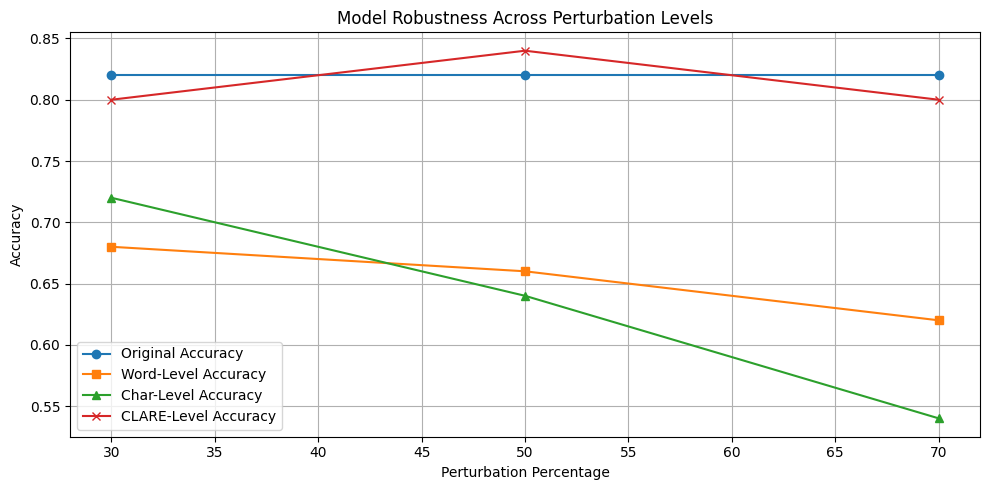

In [12]:
# === Save Results ===
df_results = pd.DataFrame(all_results)
df_results.to_csv("robustness_with_entropy.csv", index=False)

# === Plot Accuracy ===
import matplotlib.pyplot as plt

grouped = df_results.groupby("perturbation_pct").mean(numeric_only=True)

plt.figure(figsize=(10, 5))
plt.plot(grouped.index, grouped["original_correct"], marker="o", label="Original Accuracy")
plt.plot(grouped.index, grouped["word_perturbed_correct"], marker="s", label="Word-Level Accuracy")
plt.plot(grouped.index, grouped["char_perturbed_correct"], marker="^", label="Char-Level Accuracy")
plt.plot(grouped.index, grouped["clare_perturbed_correct"], marker="x", label="CLARE-Level Accuracy")
plt.xlabel("Perturbation Percentage")
plt.ylabel("Accuracy")
plt.title("Model Robustness Across Perturbation Levels")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("robustness_accuracy_plot.png")
plt.show()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
If you want to use `RobertaLMHeadModel` as a standalone, add `is_decoder=True.`


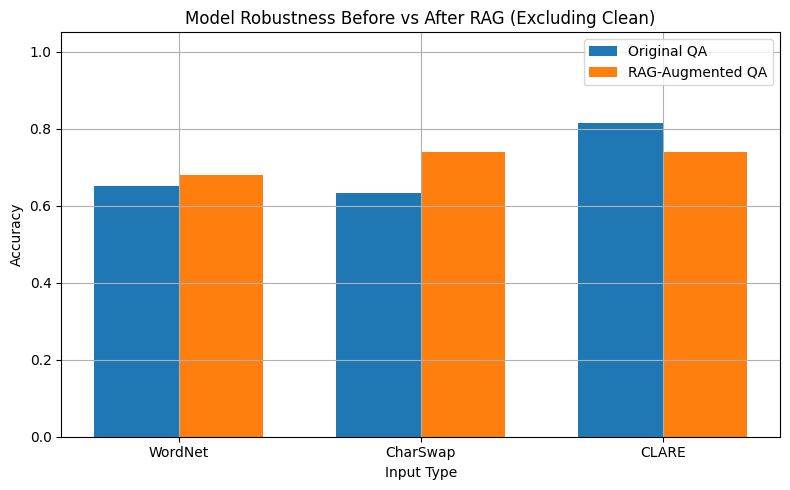

In [15]:
import torch
import re
import gc
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from textattack.augmentation import WordNetAugmenter, CharSwapAugmenter, CLAREAugmenter
from transformers import pipeline

# load previous robustness results
df = pd.read_csv("robustness_with_entropy.csv")

# prepare question + correct answer as context corpus for RAG
context_questions = [
    f"{row['question']} Answer: {row['options'][ord(row['correct_letter']) - ord('A')]}"
    for _, row in df.iterrows()
]
context_embeddings = SentenceTransformer("all-MiniLM-L6-v2").encode(context_questions, convert_to_tensor=True)

# build prompt with top-k retrieved context
def build_rag_prompt(query, opts, top_k=3):
    query_embedding = semantic_model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, context_embeddings, top_k=top_k)[0]
    context = context_questions[hits[0]["corpus_id"]]
    return (
        "You are a knowledgeable medical expert. Use the retrieved medical context to choose the best answer.\n\n"
        f"Context: {context}\n\n"
        f"Question: {query}\n\n"
        f"Options:\n"
        f"A. {opts[0]}\n"
        f"B. {opts[1]}\n"
        f"C. {opts[2]}\n"
        f"D. {opts[3]}\n\n"
        "Answer:"
    )

# evaluate accuracy with RAG prompts
def evaluate_with_rag(prompts, correct_letters):
    acc = 0
    for prompt, correct in zip(prompts, correct_letters):
        gc.collect()
        torch.cuda.empty_cache()
        out = qa_pipeline(prompt, max_new_tokens=30)[0]["generated_text"]
        pred = extract_answer_letter(out.replace(prompt, "").strip())
        acc += int(pred == correct)
    return acc / len(prompts)

# prepare RAG prompts for perturbed inputs
rag_wordnet_aug = WordNetAugmenter(pct_words_to_swap=0.5)
rag_char_aug = CharSwapAugmenter(pct_words_to_swap=0.5)
rag_clare_aug = CLAREAugmenter(transformations_per_example=1)

rag_word_prompts = [build_rag_prompt(rag_wordnet_aug.augment(q)[0], opts) for q, opts in zip(questions, options_list)]
rag_char_prompts = [build_rag_prompt(rag_char_aug.augment(q)[0], opts) for q, opts in zip(questions, options_list)]
rag_clare_prompts = [build_rag_prompt(rag_clare_aug.augment(q)[0], opts) for q, opts in zip(questions, options_list)]

# evaluate accuracy after RAG
rag_acc_word = evaluate_with_rag(rag_word_prompts, correct_letters)
rag_acc_char = evaluate_with_rag(rag_char_prompts, correct_letters)
rag_acc_clare = evaluate_with_rag(rag_clare_prompts, correct_letters)

# original pre-RAG accuracy
original_word = df.drop_duplicates(subset=["word_perturbed_question"])["word_perturbed_correct"].mean()
original_char = df.drop_duplicates(subset=["char_perturbed_question"])["char_perturbed_correct"].mean()
original_clare = df.drop_duplicates(subset=["clare_perturbed_question"])["clare_perturbed_correct"].mean()

# plot comparison
labels = ["WordNet", "CharSwap", "CLARE"]
before_accs = [original_word, original_char, original_clare]
after_rag_accs = [rag_acc_word, rag_acc_char, rag_acc_clare]

x = range(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x, before_accs, width=bar_width, label="Original QA")
plt.bar([i + bar_width for i in x], after_rag_accs, width=bar_width, label="RAG-Augmented QA")

plt.xlabel("Input Type")
plt.ylabel("Accuracy")
plt.title("Model Robustness Before vs After RAG (Excluding Clean)")
plt.xticks([i + bar_width / 2 for i in x], labels)
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("rag_vs_original_no_clean.png")
plt.show()

In [6]:
import ast
import json

print("\n=== Qualitative Examples: Model got original correct but failed all 3 attacks at 30% perturbation ===")

vulnerable_cases = df_results[
    (df_results["perturbation_pct"] == 30) &
    (df_results["original_correct"] == 1) &
    (
        (df_results["word_perturbed_correct"] == 0) |
        (df_results["char_perturbed_correct"] == 0) |
        (df_results["clare_perturbed_correct"] == 0)
    )
]

sampled = vulnerable_cases.sample(n=min(5, len(vulnerable_cases)), random_state=42)

for idx, row in sampled.iterrows():
    # Try to parse options from string safely
    raw_options = row["options"]
    try:
        options = ast.literal_eval(raw_options) if isinstance(raw_options, str) else raw_options
    except:
        try:
            options = json.loads(raw_options)
        except:
            options = ["Invalid", "Invalid", "Invalid", "Invalid"]

    def get_text(letter):
        if isinstance(letter, str) and letter in "ABCD":
            index = ord(letter) - ord("A")
            if 0 <= index < len(options):
                return options[index]
        return "Invalid"

    correct_text = get_text(row['correct_letter'])
    word_text = get_text(row['word_letter'])
    char_text = get_text(row['char_letter'])
    clare_text = get_text(row['clare_letter'])

    print("\n Perturbation Level: 30%")
    print("Question:", row['question'])
    print("Options:", options)
    print(f"Correct Answer: {row['correct_letter']} ({correct_text})")

    print(f"\n Word Attack:")
    print("Perturbed Question:", row.get('word_perturbed_question', 'N/A'))
    print(f"Prediction: {row['word_letter']} ({word_text})")

    print(f"\n Char Attack:")
    print("Perturbed Question:", row.get('char_perturbed_question', 'N/A'))
    print(f"Prediction: {row['char_letter']} ({char_text})")

    print(f"\n CLARE Attack:")
    print("Perturbed Question:", row.get('clare_perturbed_question', 'N/A'))
    print(f"Prediction: {row['clare_letter']} ({clare_text})")

    print("-" * 80)


=== Qualitative Examples: Model got original correct but failed all 3 attacks at 30% perturbation ===

 Perturbation Level: 30%
Question: Which Hodgkin’s disease is associated with best prognosis?
Options: ['Lymphocytic predominance', 'Lymphocyte depletion', 'Mixed cellularity', 'Nodular sclerosis']
Correct Answer: A (Lymphocytic predominance)

 Word Attack:
Perturbed Question: Which Hodgkin’s disease is link with safe prognosis?
Prediction: A (Lymphocytic predominance)

 Char Attack:
Perturbed Question: Which Hodgkin’s disease is assciated with beSt prognosis?
Prediction: A (Lymphocytic predominance)

 CLARE Attack:
Perturbed Question: Which Hodgkin’s disease is associated with bleak prognosis?
Prediction: B (Lymphocyte depletion)
--------------------------------------------------------------------------------

 Perturbation Level: 30%
Question: Child has received full rabies vaccination in December 2018 and now presented with oozing wound on great toe and the pet had vaccination als

In [7]:
# # ================================
# # Adversarial Finetuning with LoRA
# # ================================

# import os
# import gc
# import random
# import torch
# import matplotlib.pyplot as plt

# from transformers import (
#     AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig,
#     TrainingArguments, Trainer, DataCollatorForLanguageModeling
# )
# from datasets import Dataset
# from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
# from textattack.augmentation import WordNetAugmenter, CharSwapAugmenter, CLAREAugmenter

# # environment set up and memory, ensure that memory fragmentation is minimised
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# gc.collect()
# torch.cuda.empty_cache() # clear gpu memory for safe model loading and training

# # load the tokeniser
# tokenizer_entropy = AutoTokenizer.from_pretrained(model_id)
# tokenizer_entropy.padding_side = "left" # decoder only models require this
# tokenizer_entropy.truncation_side = "right"

# # load 8 bit quantised model and prep for LoRA
# bnb_config = BitsAndBytesConfig(load_in_8bit=True)
# model_entropy = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     quantization_config=bnb_config,
#     device_map="auto"
# )
# model_entropy = prepare_model_for_kbit_training(model_entropy)

# # apply LoRA (fo memory saving)
# lora_config = LoraConfig(
#     r=8,
#     lora_alpha=32,
#     lora_dropout=0.05,
#     bias="none",
#     task_type="CAUSAL_LM",
#     target_modules=["q_proj", "v_proj"]
# )
# model_entropy = get_peft_model(model_entropy, lora_config)
# model_entropy.print_trainable_parameters()

# # build adversarial and clean prompts
# def create_adversarial_examples(questions, options_list, wordnet_aug, char_aug, clare_aug):
#     """
#     Generate clean and adversarial prompts using 3 types of augmenters.
#     """
#     clean_prompts = []
#     adversarial_prompts = []

#     for q, opts in zip(questions, options_list):
#         clean_prompt = build_explained_prompt(q, opts)
#         clean_prompts.append(clean_prompt)

#         word_q = wordnet_aug.augment(q)[0]
#         char_q = char_aug.augment(q)[0]
#         clare_q = clare_aug.augment(q)[0]

#         adversarial_prompts.extend([
#             build_explained_prompt(word_q, opts),
#             build_explained_prompt(char_q, opts),
#             build_explained_prompt(clare_q, opts)
#         ])

#     return clean_prompts, adversarial_prompts

# # augmenters
# wordnet_aug = WordNetAugmenter(pct_words_to_swap=0.5)
# char_aug = CharSwapAugmenter(pct_words_to_swap=0.5)
# clare_aug = CLAREAugmenter(transformations_per_example=1)

# # generate prompts
# clean_prompts, adv_prompts = create_adversarial_examples(questions, options_list, wordnet_aug, char_aug, clare_aug)
# all_prompts = clean_prompts + adv_prompts
# random.shuffle(all_prompts)

# # tokenise the prompts
# tokenised_data = tokenizer_entropy(
#     all_prompts,
#     truncation=True,
#     padding="max_length",
#     max_length=256,
#     return_tensors="pt"
# )

# # wrap into a huggingface dataset
# hf_dataset = Dataset.from_dict({
#     "input_ids": tokenised_data["input_ids"],
#     "attention_mask": tokenised_data["attention_mask"],
#     "labels": tokenised_data["input_ids"]
# })

# # define training arguments
# training_args = TrainingArguments(
#     output_dir="./adv-finetuned-model",
#     per_device_train_batch_size=2,
#     gradient_accumulation_steps=4,
#     num_train_epochs=3,  # Increased to collect more loss points
#     bf16=True,
#     learning_rate=5e-5,
#     weight_decay=0.01,
#     warmup_steps=5,
#     logging_steps=1,  # Log every step
#     save_steps=50,
#     save_total_limit=1,
#     report_to="none"
# )

# # set up data collator for padding inputs in batches and assigning labels for causal language modelling
# data_collator = DataCollatorForLanguageModeling(
#     tokenizer=tokenizer_entropy,
#     mlm=False
# )

# # initialise trainer
# trainer = Trainer(
#     model=model_entropy,
#     args=training_args,
#     train_dataset=hf_dataset,
#     tokenizer=tokenizer_entropy,
#     data_collator=data_collator
# )

# # run trainer
# train_result = trainer.train()

# # save model
# trainer.save_model("./adv-finetuned-model")
# tokenizer_entropy.save_pretrained("./adv-finetuned-model")

# # =======================
# # Plot Training Loss Curve
# # =======================
# loss_history = trainer.state.log_history
# loss_vals = [log["loss"] for log in loss_history if "loss" in log]
# steps = list(range(1, len(loss_vals) + 1))

# print(f"Logged {len(loss_vals)} training loss points.")

# plt.figure(figsize=(8, 5))
# plt.plot(steps, loss_vals, marker="o", label="Training Loss")
# plt.xlabel("Logging Step")
# plt.ylabel("Loss")
# plt.title("Adversarial Training Loss Curve")
# plt.xticks(steps)
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

In [8]:
# # ===============================
# # Final Evaluation (Memory-Safe, Using CSV)
# # ===============================

# import torch
# import re
# import gc
# import pandas as pd
# import matplotlib.pyplot as plt
# from peft import PeftModel, PeftConfig
# from transformers import (
#     AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# )

# # Load robustness results CSV (make sure this was saved earlier)
# df = pd.read_csv("robustness_with_entropy.csv")

# # Extract prompts and correct answers (deduplicated to avoid repeats)
# clean_prompts = list(dict.fromkeys(df["question"].tolist()))
# word_prompts = list(dict.fromkeys(df["word_perturbed_question"].tolist()))
# char_prompts = list(dict.fromkeys(df["char_perturbed_question"].tolist()))
# correct_letters = list(dict.fromkeys(df["correct_letter"].tolist()))

# # Load LoRA adapter and base model
# peft_config = PeftConfig.from_pretrained("./adv-finetuned-model")

# bnb_config = BitsAndBytesConfig(
#     load_in_8bit=True,
#     llm_int8_enable_fp32_cpu_offload=True  # allow CPU fallback
# )

# base_model = AutoModelForCausalLM.from_pretrained(
#     peft_config.base_model_name_or_path,
#     quantization_config=bnb_config,
#     device_map="auto"
# )

# model_finetuned = PeftModel.from_pretrained(base_model, "./adv-finetuned-model")

# tokenizer_finetuned = AutoTokenizer.from_pretrained(peft_config.base_model_name_or_path)
# tokenizer_finetuned.padding_side = "left"
# tokenizer_finetuned.truncation_side = "right"

# # Determine the actual compute device
# def get_model_device(model):
#     for param in model.parameters():
#         if param.device != torch.device("meta"):
#             return param.device
#     return torch.device("cpu")

# model_device = get_model_device(model_finetuned)

# # Extract letter from output string
# def extract_answer_letter(text):
#     match = re.search(r"\b([A-D])\b", text.upper())
#     return match.group(1) if match else ""

# # Evaluate prompts using generate()
# def evaluate_prompts_raw(prompts, correct_letters):
#     model_finetuned.eval()
#     acc = 0

#     for prompt, correct in zip(prompts, correct_letters):
#         gc.collect()
#         torch.cuda.empty_cache()

#         inputs = tokenizer_finetuned(prompt, return_tensors="pt", truncation=True, padding=True)
#         inputs = {k: v.to(model_device) for k, v in inputs.items()}

#         with torch.inference_mode():
#             output = model_finetuned.generate(**inputs, max_new_tokens=30)

#         decoded = tokenizer_finetuned.decode(output[0], skip_special_tokens=True)
#         pred = extract_answer_letter(decoded.replace(prompt, "").strip())
#         acc += int(pred == correct)

#         del inputs, output
#         gc.collect()
#         torch.cuda.empty_cache()

#     return acc / len(prompts)

# # Evaluate accuracy after finetuning
# acc_clean = evaluate_prompts_raw(clean_prompts, correct_letters)
# acc_word = evaluate_prompts_raw(word_prompts, correct_letters)
# acc_char = evaluate_prompts_raw(char_prompts, correct_letters)

# # Compute accuracy before finetuning from earlier results
# correct_original = df.drop_duplicates(subset=["question"])["original_correct"].mean()
# correct_word = df.drop_duplicates(subset=["word_perturbed_question"])["word_perturbed_correct"].mean()
# correct_char = df.drop_duplicates(subset=["char_perturbed_question"])["char_perturbed_correct"].mean()

# # Plot comparison
# labels = ["Clean", "WordNet", "CharSwap"]
# before_accs = [correct_original, correct_word, correct_char]
# after_accs = [acc_clean, acc_word, acc_char]

# x = range(len(labels))
# bar_width = 0.35

# plt.figure(figsize=(8, 5))
# plt.bar(x, before_accs, width=bar_width, label="Before Finetuning")
# plt.bar([i + bar_width for i in x], after_accs, width=bar_width, label="After Finetuning")

# plt.xlabel("Input Type")
# plt.ylabel("Accuracy")
# plt.title("Model Robustness Before vs After Adversarial Training (No CLARE)")
# plt.xticks([i + bar_width / 2 for i in x], labels)
# plt.ylim(0, 1.05)
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()